In [1]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from minisom import MiniSom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Create a Spark session
spark = SparkSession.builder.appName('SOMClustering').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/24 22:50:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/02/24 22:50:04 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# Load the dataset
df = spark.read.csv('Mall_Customers.csv', header=True, inferSchema=True)

In [4]:
df.show()

+----------+------+---+------------------+----------------------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         1|  Male| 19|                15|                    39|
|         2|  Male| 21|                15|                    81|
|         3|Female| 20|                16|                     6|
|         4|Female| 23|                16|                    77|
|         5|Female| 31|                17|                    40|
|         6|Female| 22|                17|                    76|
|         7|Female| 35|                18|                     6|
|         8|Female| 23|                18|                    94|
|         9|  Male| 64|                19|                     3|
|        10|Female| 30|                19|                    72|
|        11|  Male| 67|                19|                    14|
|        12|Female| 35|                19|                    99|
|        1

In [5]:
df_vs = df.toPandas()

<AxesSubplot:>

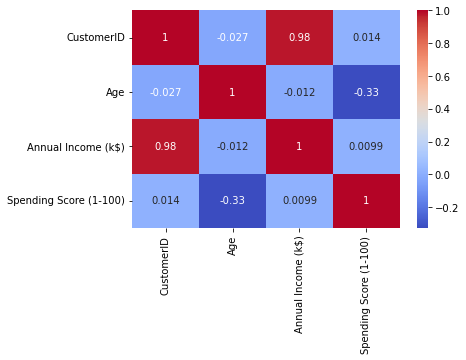

In [6]:

corr_matrix = df_vs.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

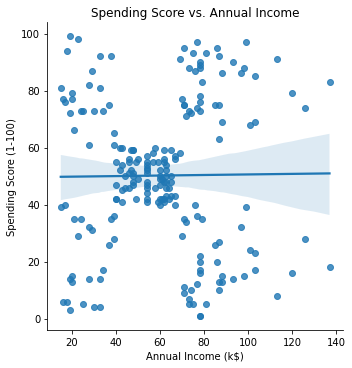

In [7]:
sns.lmplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df_vs)
plt.title('Spending Score vs. Annual Income')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

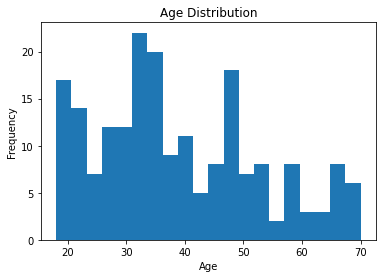

In [8]:
# Plot histogram of Age distribution
plt.hist(df_vs['Age'], bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

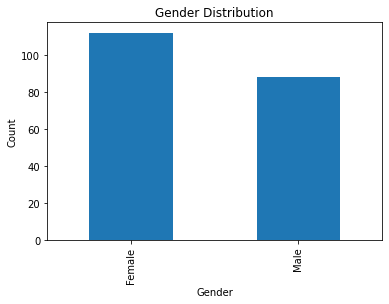

In [9]:
# Plot bar plot of Gender Distribution
df_vs['Gender'].value_counts().plot(kind='bar')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

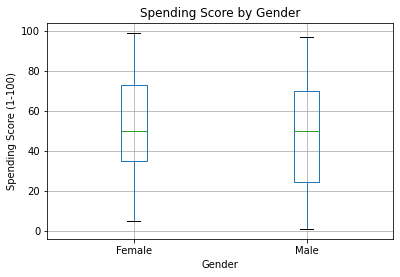

In [10]:
# Plot box plot of Spending Score by Gender
df_vs.boxplot(column='Spending Score (1-100)', by='Gender')
plt.title('Spending Score by Gender')
plt.xlabel('Gender')
plt.ylabel('Spending Score (1-100)')
plt.suptitle('')
plt.show()

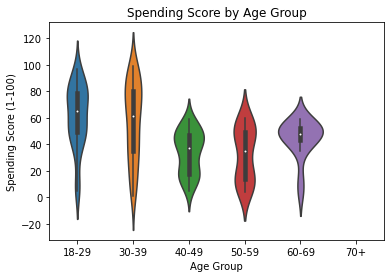

In [11]:
# Define age groups
bins = [18, 30, 40, 50, 60, 70, 80]
labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+']
df_vs['Age Group'] = pd.cut(df_vs['Age'], bins=bins, labels=labels)

# Plot violin plot of Spending Score by Age Group
sns.violinplot(x='Age Group', y='Spending Score (1-100)', data=df_vs)
plt.title('Spending Score by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Spending Score (1-100)')
plt.show()

In [12]:
# Select relevant features
df = df.select(['Annual Income (k$)', 'Spending Score (1-100)'])

In [13]:
# Convert Spark DataFrame to Pandas DataFrame
df_pd = df.toPandas()

In [14]:
df_pd

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
...,...,...
195,120,79
196,126,28
197,126,74
198,137,18


In [15]:
# Define the VectorAssembler to create a features column
assembler = VectorAssembler(inputCols=df.columns, outputCol="features")

In [16]:
# Scale the data using StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [17]:
# Define the pipeline for scaling and assembling
pipeline = Pipeline(stages=[assembler, scaler])

In [18]:
# Fit and transform the data
pipeline_model = pipeline.fit(df)
scaled_data = pipeline_model.transform(df)

In [19]:
# Convert scaled data to numpy array
scaled_data_np = np.array(scaled_data.select('scaledFeatures').collect()).squeeze()

In [20]:
# Train the SOM
som = MiniSom(x=10, y=10, input_len=2, sigma=1.0, learning_rate=0.5)
som.random_weights_init(scaled_data_np)
som.train_random(scaled_data_np, num_iteration=100)

In [21]:
# Assign cluster labels to each data point
clusters = som.win_map(scaled_data_np)
labels_map = som.labels_map(scaled_data_np, df_pd.index)
labels = np.zeros(len(df_pd), dtype=int)
for i, loc in enumerate(df_pd.index):
    if loc in labels_map:
        labels[i] = labels_map[loc][0]

In [22]:
# Add cluster labels to Spark DataFrame
df_pd = df_pd.assign(cluster=pd.Series(labels).values)

In [23]:
# Show the resulting clusters
print(df_pd)

     Annual Income (k$)  Spending Score (1-100)  cluster
0                    15                      39        0
1                    15                      81        0
2                    16                       6        0
3                    16                      77        0
4                    17                      40        0
..                  ...                     ...      ...
195                 120                      79        0
196                 126                      28        0
197                 126                      74        0
198                 137                      18        0
199                 137                      83        0

[200 rows x 3 columns]


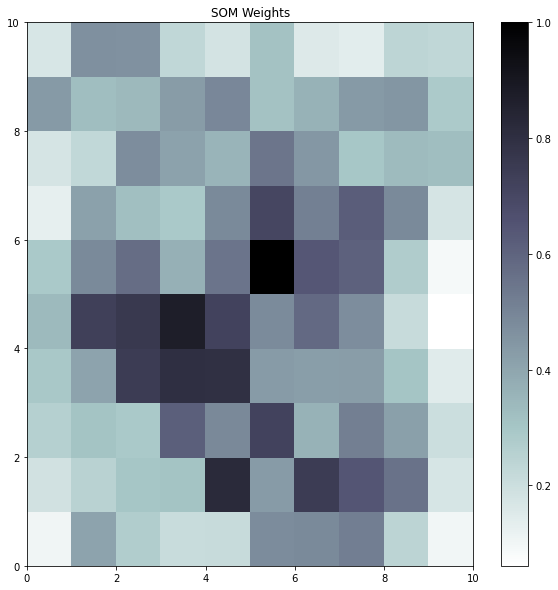

In [24]:
# Plot the SOM weights and the data distribution
plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()
plt.title('SOM Weights')
plt.show()

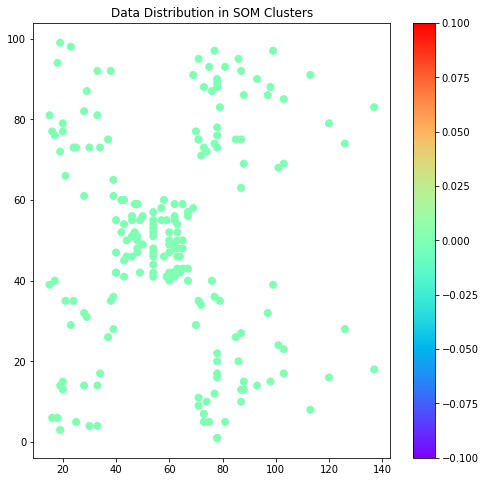

In [25]:
plt.figure(figsize=(8, 8))
plt.scatter(df_pd.iloc[:, 0], df_pd.iloc[:, 1], s=50, c=df_pd['cluster'], cmap='rainbow')
plt.colorbar()
plt.title('Data Distribution in SOM Clusters')
plt.show()

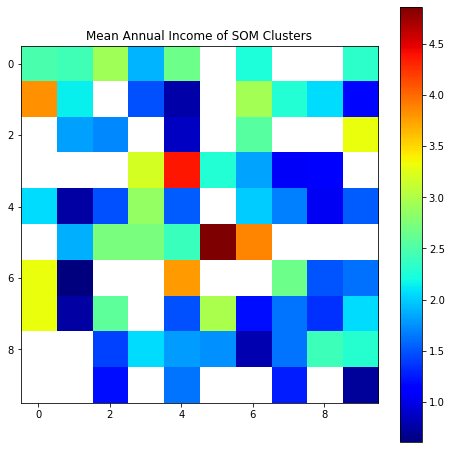

Text(0.5, 1.0, 'Mean Spending Score of SOM')

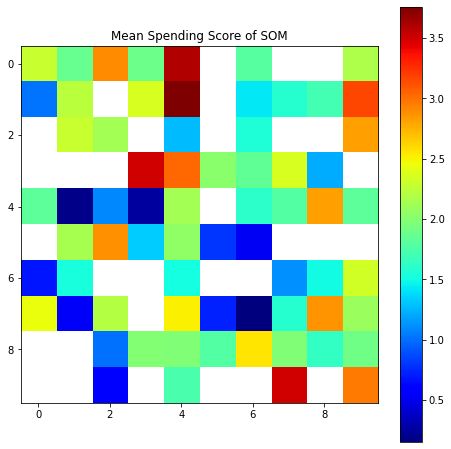

In [26]:
# Plot the mean feature values of each cluster
cluster_centers = som.get_weights()
cluster_means = np.zeros((10, 10, 2))
for i in range(10):
    for j in range(10):
        cluster_members = np.array(list(clusters[(i, j)]))
        if len(cluster_members) > 0:
            cluster_means[i, j] = np.mean(cluster_members, axis=0)
        else:
            cluster_means[i, j] = np.nan
plt.figure(figsize=(8, 8))
plt.imshow(cluster_means[..., 0], cmap='jet', interpolation='nearest')
plt.colorbar()
plt.title('Mean Annual Income of SOM Clusters')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(cluster_means[..., 1], cmap='jet', interpolation='nearest')
plt.colorbar()
plt.title('Mean Spending Score of SOM')